In [1]:
import gym
import MCTSnet
import copy
import torch

# Testing environment

In [2]:
env = gym.make("SokobanEnc-v0")

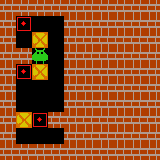

In [3]:
env.render()

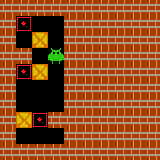

In [4]:
res = env.step(3)
env.render()

# Testing the four neural networks

In [5]:
e = MCTSnet.models.embedding.Epsilon()

In [6]:
state = torch.Tensor(res[0])
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [7]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [8]:
reward = torch.tensor([res[1]], requires_grad=True)
action = torch.tensor([3.], requires_grad=True)

In [9]:
b = MCTSnet.models.backup.BetaMLP()

In [10]:
h_s = b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

In [11]:
r = MCTSnet.models.readout.Rho()

In [12]:
r(h_s)

tensor([[0.1239, 0.1248, 0.1313, 0.1272, 0.1116, 0.1235, 0.1310, 0.1267]],
       grad_fn=<SoftmaxBackward>)

In [13]:
pi = MCTSnet.models.policy.Pi()
actions = pi(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape(-1, 9, 128))

In [14]:
actions

tensor([[0.1240, 0.1304, 0.1243, 0.1215, 0.1271, 0.1250, 0.1268, 0.1209]],
       grad_fn=<SoftmaxBackward>)

In [15]:
torch.argmax(actions)

tensor(1)

In [16]:
state.shape

torch.Size([4, 10, 10])

# Testing the full MCTSnet

In [17]:
m_net = MCTSnet.models.MCTSnet.MCTSnet(env, b, e, pi, r)
m_net.reset_tree(state.reshape((-1, 4, 10, 10)))
prediction = m_net(state.reshape((-1, 4, 10, 10)))

In [18]:
prediction

tensor([[0.1219, 0.1230, 0.1342, 0.1258, 0.1171, 0.1238, 0.1259, 0.1282]],
       grad_fn=<SoftmaxBackward>)

In [19]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(m_net.parameters(), lr=0.0001)

### Checking that gradients are computed (is the model differentiable ?)

In [20]:
optimizer.zero_grad()
loss = criterion(prediction, torch.tensor([[1.,0.,0.,0.,0.,0.,0.,0.]]))
loss.backward()

In [28]:
m_net.backup.fc1.weight.grad

tensor([[ 2.7878e-04, -1.5192e-08,  2.3460e-04,  ...,  0.0000e+00,
         -1.2648e-03,  1.2648e-02],
        [ 0.0000e+00,  1.7888e-08,  7.5133e-09,  ...,  0.0000e+00,
         -2.2308e-08,  2.2308e-07],
        [-9.1358e-05, -2.4121e-08, -7.6811e-05,  ...,  0.0000e+00,
          4.1319e-04, -4.1319e-03],
        ...,
        [-3.5190e-05, -3.0203e-09, -2.9628e-05,  ...,  0.0000e+00,
          1.6046e-04, -1.6046e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00]])

In [29]:
m_net.embedding.input.weight.grad

tensor([[[[-2.3999e-08,  3.6270e-09, -1.8610e-08],
          [-6.4656e-08, -5.4420e-08, -4.1927e-08],
          [ 0.0000e+00, -1.6351e-10,  1.9553e-08]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -4.7303e-09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00, -4.7303e-09,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -1.6351e-10],
          [ 2.4182e-08, -4.7303e-09,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.5382e-09,  1.6266e-08,  0.0000e+00]]],


        [[[-3.5222e-08, -8.2309e-09, -2.6388e-08],
          [-3.6939e-08, -2.1827e-08, -3.2125e-08],
          [-5.4436e-08, -3.8190e-08, -3.4126e-08]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 6.9295e-09,  0.0000e+00, -4.8753e-09],
          [ 4.9345e-09,  0.0000e+00, -6.7748e-10]],

         [[ 0.0000e+00, -8.9300e-09, -3.5304e-09],
          [ 0.000

as "expected" the policy doesn't learn and may require additionnal work

In [34]:
m_net.policy.piPL.input.weight.grad

In [32]:
m_net.readout.fc1.weight.grad

tensor([[-0.0028, -0.0000, -0.0023,  ..., -0.0040, -0.0000, -0.0000],
        [ 0.0004,  0.0000,  0.0003,  ...,  0.0006,  0.0000,  0.0000],
        [ 0.0004,  0.0000,  0.0004,  ...,  0.0006,  0.0000,  0.0000],
        ...,
        [ 0.0004,  0.0000,  0.0003,  ...,  0.0006,  0.0000,  0.0000],
        [ 0.0004,  0.0000,  0.0003,  ...,  0.0006,  0.0000,  0.0000],
        [ 0.0004,  0.0000,  0.0003,  ...,  0.0006,  0.0000,  0.0000]])